In [121]:
# Nikhil Patil
# CSEC 620 Project 2
# K-Nearest Neighbors Implementation 
import re, random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

WINE_DATA = pd.read_csv("./wine/wine.data") 
IRIS_DATA = pd.read_csv("./Iris/iris.data")

class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)
    
    def _predict(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [122]:
def get_column_names():
    wine_names = "./wine/wine.names"
    iris_names = "./Iris/iris.names"
    wine_columns = []
    iris_columns = []
    
    wine_line_counter = 0
    iris_line_counter = 0
    class_identifier = ""
    with open(wine_names) as f:
        for line in f:
            wine_line_counter += 1
            if(wine_line_counter > 57 and wine_line_counter <= 70):
                line = line.strip()
                wine_columns.append(line)
            if wine_line_counter == 75:
                line = line.strip()
                class_identifier = re.search(r'\bclass\b', line)
    f.close()
    wine_columns =  [re.sub(r'^\d+\)\s*', '', column) for column in wine_columns]
    wine_columns.insert(0, class_identifier.group())
    with open(iris_names) as f:
        for line in f:
            iris_line_counter += 1
            if(iris_line_counter > 50 and iris_line_counter < 56):
                line = line.strip()
                iris_columns.append(line)
    f.close()
    iris_columns =  [re.sub(r'^\d+\.\s*', '', column) for column in iris_columns]
    
    print(wine_columns)
    print(iris_columns)
    
    return wine_columns, iris_columns

In [123]:
def load_and_preprocess_data(data, column_names):
    global actual_labels
    df = data.copy()
    df.columns = column_names
    
    if data is IRIS_DATA:
        df['class:'] = df['class:'].map({'Iris-setosa' : 1,  'Iris-versicolor' : 2, 'Iris-virginica' : 3}) 
        actual_labels = df['class:'].values
        df.drop("class:", axis=1, inplace=True) 
        
    if data is WINE_DATA:
        actual_labels = df['class'].values
        df.drop("class", axis=1, inplace=True)
    
    scaler = StandardScaler()
    transformed_features = scaler.fit_transform(df)
    
    return transformed_features, actual_labels

In [124]:
def plot_knn_scatter(X, y_pred):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)

    
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['Predicted Class'] = y_pred

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Predicted Class', palette='viridis', s=100, alpha=0.8)
    plt.title("KNN Classification Scatter Plot")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Predicted Class', loc='best')
    plt.show()

In [125]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel("Predicted Classes")
    plt.ylabel("True Classes")
    plt.title("Confusion Matrix")
    plt.show()

In [126]:
def plot_decision_boundary(knn, X, y, resolution=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("KNN Decision Boundary (k = %i)" % knn.k)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

In [127]:
def wine_classification(wine_columns):
    features, labels = load_and_preprocess_data(WINE_DATA, wine_columns)
    
    pca = PCA(n_components=2)
    pca_transformed_features = pca.fit_transform(features)
    
    X_train, X_test, y_train, y_test = train_test_split(pca_transformed_features, labels, test_size=0.4, random_state=random.randint(1,1000))
    
    knn_classifier = KNearestNeighbors(k=3)
    knn_classifier.fit(X_train, y_train)
    
    predictions = knn_classifier.predict(X_test)
    predictions = np.array(predictions)
    y_test_wine = np.array(y_test)
    
    accuracy_wine = np.mean(predictions == y_test)
    print(f"Accuracy on Wine Dataset: {accuracy_wine:.2f}")
    plot_decision_boundary(knn_classifier, X_test, y_test)
    plot_knn_scatter(X_test, predictions)
    classes = ['Wine 1', 'Wine 2', 'Wine 3'] 
    plot_confusion_matrix(y_test_wine, predictions, classes)

In [128]:
def iris_classification(iris_columns):
    features, labels = load_and_preprocess_data(IRIS_DATA, iris_columns)
    
    pca = PCA(n_components=2)
    pca_transformed_features = pca.fit_transform(features)
    
    X_train, X_test, y_train, y_test = train_test_split(pca_transformed_features, labels, test_size=0.4, random_state=random.randint(1,1000))
    
    knn_classifier = KNearestNeighbors(k=3)
    knn_classifier.fit(X_train, y_train)
    
    predictions = knn_classifier.predict(X_test)
    predictions = np.array(predictions)
    y_test_wine = np.array(y_test)
    
    accuracy_wine = np.mean(predictions == y_test)
    print(f"Accuracy on Iris Dataset: {accuracy_wine:.2f}")
    plot_decision_boundary(knn_classifier, X_test, y_test) # fuuuuuck
    plot_knn_scatter(X_test, predictions)
    classes = ['Iris Setosa', 'Iris Versicolor', 'Iris Virginica'] 
    plot_confusion_matrix(y_test_wine, predictions, classes)

In [129]:
def classify():
    wine_columns, iris_columns = get_column_names()
    wine_classification(wine_columns)
    iris_classification(iris_columns)

['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm', 'class:']
Accuracy on Wine Dataset: 0.94


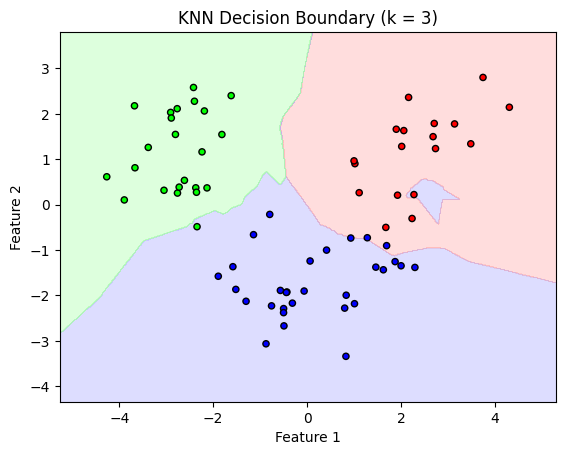

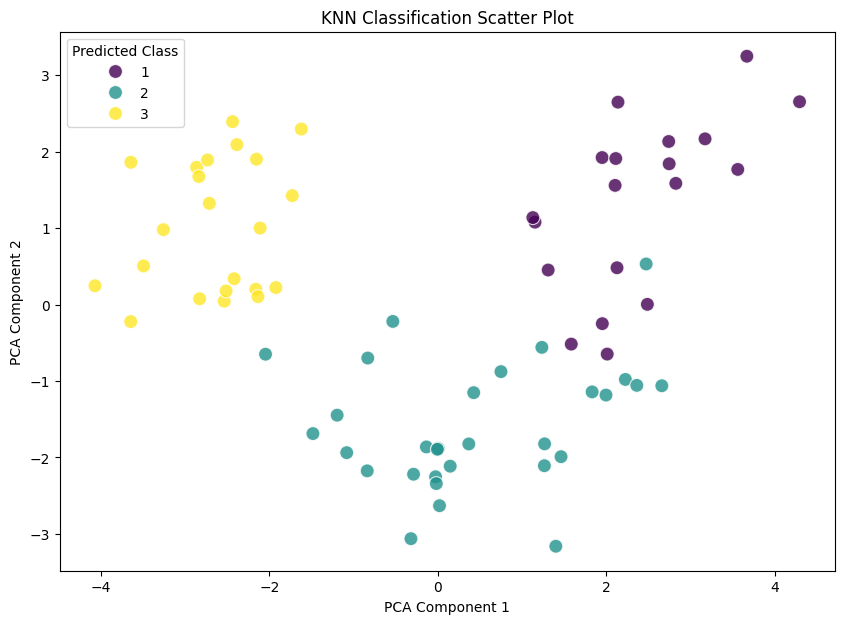

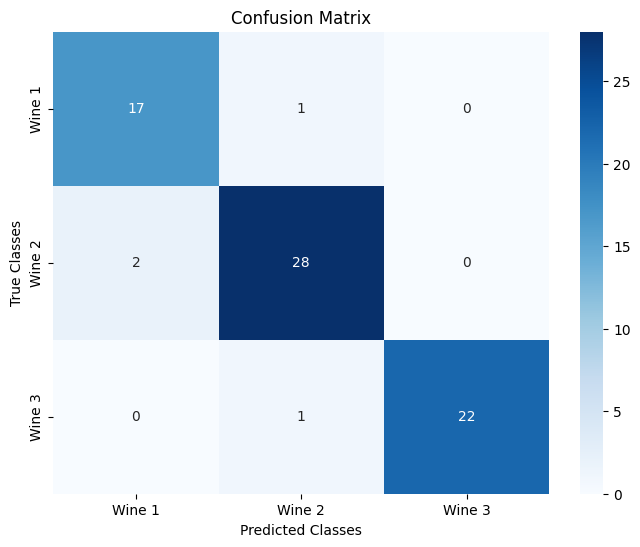

Accuracy on Iris Dataset: 0.88


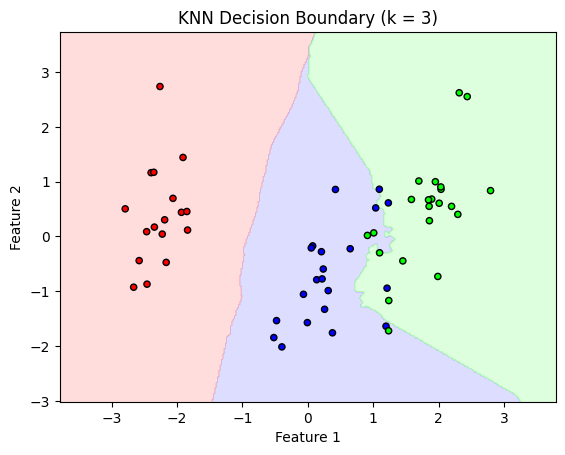

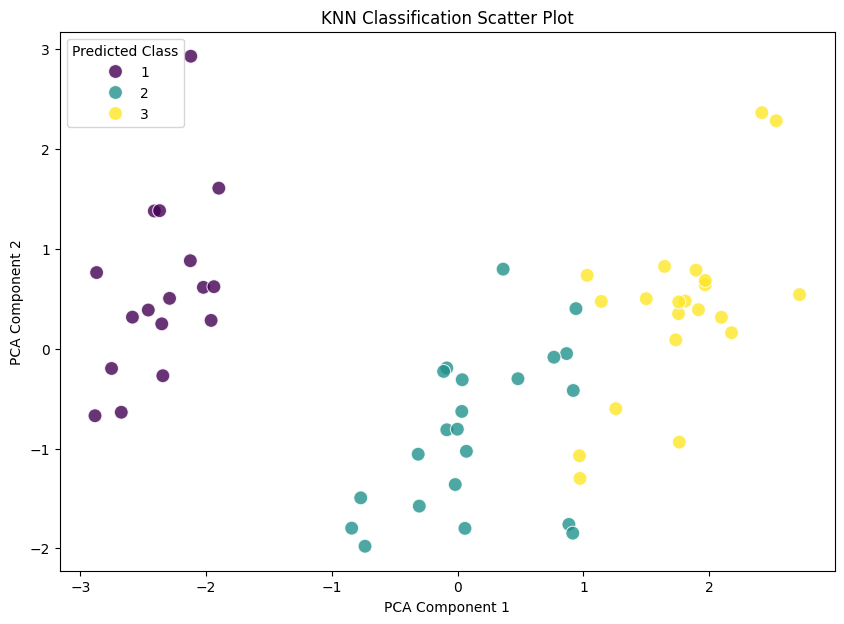

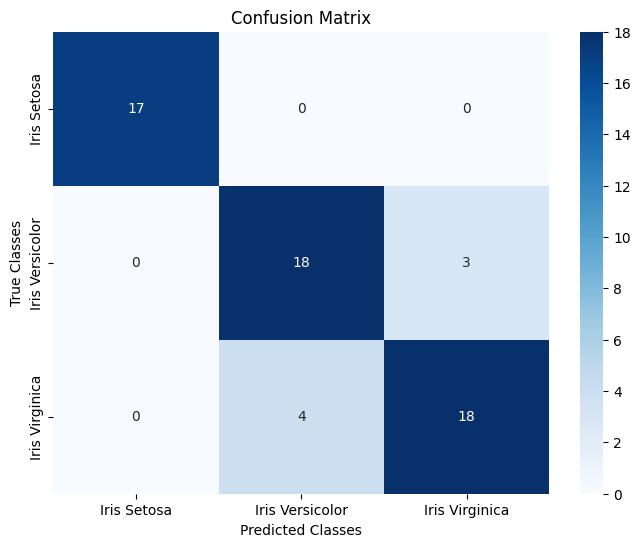

In [130]:
def main():
    classify()
    
if __name__ == "__main__":
    main()